# Exploratory Data Analysis of 3D Medical Images

This notebook performs an exploratory data analysis (EDA) on the training dataset located in `app/data/imagesTr` and `app/data/labelsTr`. The goal is to check class balance, visualize examples, and ensure data quality.

## 1. Import Libraries
We import the necessary libraries for data loading, processing, and visualization.

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import pandas as pd
from glob import glob
from collections import Counter
%matplotlib inline

## 2. Data Loading
We list and load a few sample images and their corresponding labels.

In [9]:
print("Current working directory:", os.getcwd())
print("Files in current directory:", os.listdir())

images_dir = 'data/imagesTr'
labels_dir = 'data/labelsTr'

image_files = sorted(glob(os.path.join(images_dir, '*.nii.gz')))
label_files = sorted(glob(os.path.join(labels_dir, '*.nii.gz')))

print(f'Number of images: {len(image_files)}')
print(f'Number of labels: {len(label_files)}')
print("Sample image files:", image_files[:3])
print("Sample label files:", label_files[:3])

Current working directory: c:\Users\franc\Documents\UNIVERSIDAD\INVESTIGACION\QML-HILBERT\app
Files in current directory: ['analysis_data.ipynb', 'data', 'delete', 'hilbert_curve.py', 'pen.py', 'pen_hilbert.py', 'requirements.txt', 'results', 'results.py', 'results_hilbert.py', 'results_hilbert_log.csv', 'results_log.csv']
Number of images: 484
Number of labels: 484
Sample image files: ['data/imagesTr\\BRATS_001.nii.gz', 'data/imagesTr\\BRATS_002.nii.gz', 'data/imagesTr\\BRATS_003.nii.gz']
Sample label files: ['data/labelsTr\\BRATS_001.nii.gz', 'data/labelsTr\\BRATS_002.nii.gz', 'data/labelsTr\\BRATS_003.nii.gz']


In [23]:
import nibabel as nib
import numpy as np

# Ruta al archivo de segmentación
seg_path = 'data/labelsTr/BRATS_109.nii.gz'

# Cargar volumen
seg = nib.load(seg_path).get_fdata()

# Verificar si hay algún voxel con valor distinto de 0
has_tumor = np.any(seg > 0)

print("¿Hay tumor?", has_tumor)  # True o False


¿Hay tumor? True


## 3. Basic Exploration
We check the dimensions of the images and labels, and gather basic statistics.

In [10]:
# Load a sample image and label
sample_img = nib.load(image_files[0]).get_fdata()
sample_lbl = nib.load(label_files[0]).get_fdata()

print('Sample image shape:', sample_img.shape)
print('Sample label shape:', sample_lbl.shape)

# Check unique values in the label
unique_classes = np.unique(sample_lbl)
print('Unique classes in sample label:', unique_classes)

Sample image shape: (240, 240, 155, 4)
Sample label shape: (240, 240, 155)
Unique classes in sample label: [0. 1. 2. 3.]


## 4. Class Balance Analysis
We analyze the distribution of classes across all label volumes.

Class voxel counts: Counter({np.float64(0.0): np.int64(4271154985), np.float64(1.0): np.int64(31456687), np.float64(3.0): np.int64(9808761), np.float64(2.0): np.int64(8731567)})


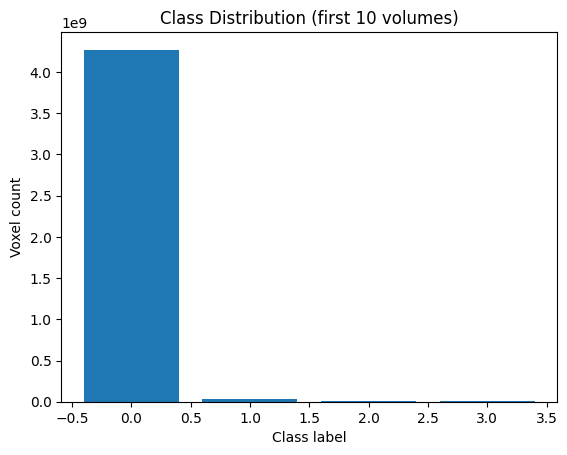

In [14]:
class_counts = Counter()
for lbl_path in label_files:  # Use a subset for speed; remove [:10] for full dataset
    lbl = nib.load(lbl_path).get_fdata()
    vals, counts = np.unique(lbl, return_counts=True)
    for v, c in zip(vals, counts):
        class_counts[v] += c

print('Class voxel counts:', class_counts)

# Plot class distribution
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class label')
plt.ylabel('Voxel count')
plt.title('Class Distribution (first 10 volumes)')
plt.show()

Volumes with tumor: 484
Volumes without tumor: 0


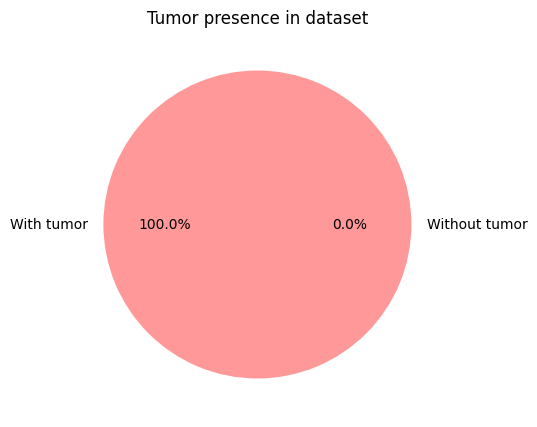

In [15]:
# Tumor presence analysis per volume
tumor_volumes = 0
no_tumor_volumes = 0

for lbl_path in label_files:
    lbl = nib.load(lbl_path).get_fdata()
    if np.any(lbl > 0):
        tumor_volumes += 1
    else:
        no_tumor_volumes += 1

print(f"Volumes with tumor: {tumor_volumes}")
print(f"Volumes without tumor: {no_tumor_volumes}")

# Pie chart for visualization
plt.figure(figsize=(5, 5))
plt.pie([tumor_volumes, no_tumor_volumes], labels=['With tumor', 'Without tumor'], autopct='%1.1f%%', colors=['#ff9999','#66b3ff'])
plt.title('Tumor presence in dataset')
plt.show()

In [16]:
from tqdm import tqdm
import seaborn as sns

def extract_slices(volume, label, axis=2, step=1):
    slices, labels = [], []
    for i in range(0, volume.shape[axis], step):
        img_slice = np.take(volume, i, axis=axis)
        lbl_slice = np.take(label, i, axis=axis)
        slices.append(img_slice)
        # Label as 1 if there is any tumor voxel in the slice, else 0
        labels.append(1 if np.any(lbl_slice > 0) else 0)
    return slices, labels

all_slices, all_labels = [], []
for img_path, lbl_path in tqdm(zip(image_files, label_files), total=len(image_files), desc='Extracting slices'):
    img = nib.load(img_path).get_fdata()
    lbl = nib.load(lbl_path).get_fdata()
    # If image has multiple channels, take the first channel for visualization
    if img.ndim == 4:
        img = img[..., 0]
    slices, labels = extract_slices(img, lbl, axis=2, step=1)
    all_slices.extend(slices)
    all_labels.extend(labels)
all_slices = np.stack(all_slices)
all_labels = np.array(all_labels)
print('Total slices:', all_slices.shape, 'Positive (tumor) slices:', all_labels.sum())

# Plot slice-level class distribution
sns.countplot(x=all_labels)
plt.title('Slice-level class distribution (0: no tumor, 1: tumor)')
plt.xlabel('Slice label')
plt.ylabel('Count')
plt.show()

# Show examples of positive (tumor) slices
fig, ax = plt.subplots(1, 4, figsize=(12, 3))
pos_indices = np.where(all_labels == 1)[0][:4]
for i, idx in enumerate(pos_indices):
    ax[i].imshow(all_slices[idx], cmap='gray')
    ax[i].set_title('Tumor')
    ax[i].axis('off')
plt.tight_layout()
plt.show()

# Show examples of negative (no tumor) slices
fig, ax = plt.subplots(1, 4, figsize=(12, 3))
neg_indices = np.where(all_labels == 0)[0][:4]
for i, idx in enumerate(neg_indices):
    ax[i].imshow(all_slices[idx], cmap='gray')
    ax[i].set_title('No tumor')
    ax[i].axis('off')
plt.tight_layout()
plt.show()

Extracting slices: 100%|██████████| 484/484 [2:30:22<00:00, 18.64s/it]  


MemoryError: Unable to allocate 32.2 GiB for an array with shape (75020, 240, 240) and data type float64

## 5. Visualization
We visualize slices from the 3D images and their corresponding labels.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2238.0].


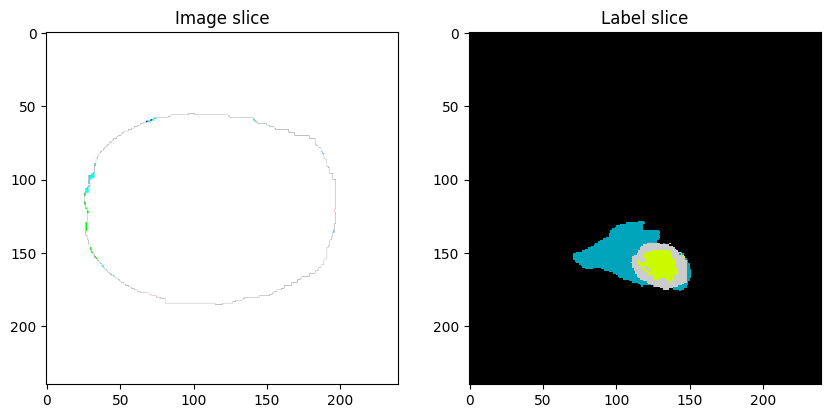

In [17]:
def plot_slices(image, label, slice_idx=None):
    if slice_idx is None:
        slice_idx = image.shape[2] // 2  # Middle slice
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(image[:, :, slice_idx], cmap='gray')
    axs[0].set_title('Image slice')
    axs[1].imshow(label[:, :, slice_idx], cmap='nipy_spectral', interpolation='none')
    axs[1].set_title('Label slice')
    plt.show()

# Plot a slice from the first sample
plot_slices(sample_img, sample_lbl)

## 6. Data Quality Checks
We check for empty images, empty labels, or unexpected values.

In [18]:
# Check for empty or problematic files in a subset
for img_path, lbl_path in zip(image_files[:10], label_files[:10]):
    img = nib.load(img_path).get_fdata()
    lbl = nib.load(lbl_path).get_fdata()
    if np.all(img == 0):
        print(f'Warning: Image {img_path} is empty!')
    if np.all(lbl == 0):
        print(f'Warning: Label {lbl_path} is empty!')
    if np.any(np.isnan(img)) or np.any(np.isnan(lbl)):
        print(f'Warning: NaN values found in {img_path} or {lbl_path}')
    # Add more checks as needed


## 7. Conclusions
Summarize the findings of the exploratory analysis.